In [705]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib.table import Table
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from datetime import timedelta
from statistics import mode
from scipy.signal import find_peaks
from scipy import signal

import ast

# Libraries for Correlations
from scipy.stats import pearsonr, sem, variation, kruskal,f_oneway 
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

%matplotlib inline


############################################

Processing the Glucose Values to Isolate the PPGR

############################################

In [706]:
def read_data(filename):
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], dayfirst=True)
    unfiltered['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'], dayfirst=True)
    unfiltered['bolus_start_ts'] = pd.to_datetime(unfiltered['bolus_start_ts'], dayfirst=True)

    # Convert glucose levels from mg/dL to mmol/L
    unfiltered['glucose_level_mg/dL'] = (unfiltered['glucose_level_mg/dL'] * 0.0555).round(2)
    
    return unfiltered


In [707]:
def interleave_arrays_increasing(meal, bolus):
    result = []
    i, j = 0, 0
    while i < len(meal) and j < len(bolus):
        if meal[i] < bolus[j]:
            result.append(("meal", meal[i]))
            i += 1
        else:
            result.append(("bolus", bolus[j]))
            j += 1
    result.extend([("meal", meal[x]) for x in range(i, len(meal))])
    result.extend([("bolus", bolus[x]) for x in range(j, len(bolus))])
    return result


In [708]:
def glucoseForMealsTs(glucose_ts_array, meal_ts):
    closest_values = []
    for element in meal_ts:
        closest_index = np.abs(glucose_ts_array - element).argmin()
        closest_values.append(glucose_ts_array[closest_index])
    return np.array(closest_values)


In [709]:
def glucoseForEventsTs(glucose_ts_array, events_ts):
    closest_values = []
    for event_type, event_ts in events_ts:
        closest_index = np.abs(glucose_ts_array - event_ts).argmin()
        closest_value = glucose_ts_array[closest_index]
        
        if abs(closest_value - event_ts) <= pd.Timedelta(hours=4):
            closest_values.append((event_type, event_ts, closest_value))
    
    return closest_values


In [710]:
def bolusMealSeparation(meal_ts, bolus_start_ts, bolus_dose_filtered):
    viableBolusTimes = []
    for i in range(min(len(bolus_start_ts), len(bolus_dose_filtered))):
        isWithinRange = False
        for j in range(len(meal_ts)):
            if meal_ts[j] - pd.Timedelta(minutes=4) <= bolus_start_ts[i] <= meal_ts[j] + pd.Timedelta(hours=4):
                isWithinRange = True
                break
        if not isWithinRange:
            viableBolusTimes.append((bolus_start_ts[i], bolus_dose_filtered[i]))
    return viableBolusTimes


In [711]:
def groupBolus2(bolus_array):
    time_ranges = [
        ("6am-10am", datetime.time(6, 0), datetime.time(10, 0)),
        ("10am-2pm", datetime.time(10, 0), datetime.time(14, 0)),
        ("2pm-6pm", datetime.time(14, 0), datetime.time(18, 0)),
        ("6pm-10pm", datetime.time(18, 0), datetime.time(22, 0)),
    ]

    result = []
    df = pd.DataFrame(bolus_array, columns=['Timestamp', 'Value'])
    grouped = df.groupby(df['Timestamp'].dt.date)

    for date, group_data in grouped:
        daily_result = {'Date': date, 'TimeRanges': []}
        for label, start_time, end_time in time_ranges:
            time_mask = (group_data['Timestamp'].dt.time >= start_time) & (group_data['Timestamp'].dt.time < end_time)
            max_value = group_data.loc[time_mask, 'Value'].max()
            max_timestamps = group_data.loc[(time_mask) & (group_data['Value'] == max_value), 'Timestamp'].tolist()
            daily_result['TimeRanges'].append({
                'TimeRange': label,
                'MaxValue': max_value,
                'Timestamps': max_timestamps
            })
        result.append(daily_result)
    return result



In [712]:
def findTimestampsNotCoveredByMeals(result, meal_events):
    time_ranges = {
        "6am-10am": (datetime.time(6, 0), datetime.time(10, 0)),
        "10am-2pm": (datetime.time(10, 0), datetime.time(14, 0)),
        "2pm-6pm": (datetime.time(14, 0), datetime.time(18, 0)),
        "6pm-10pm": (datetime.time(18, 0), datetime.time(22, 0))
    }

    meal_events_set = set(meal_events)
    timestamps_not_covered = []

    for day_result in result:
        for time_range_result in day_result['TimeRanges']:
            time_range_label = time_range_result['TimeRange']
            timestamps = time_range_result['Timestamps']
            time_range_start, time_range_end = time_ranges[time_range_label]

            meal_events_within_range = False
            for meal in meal_events_set:
                meal_time = meal.time()
                time_range_start_datetime = datetime.datetime.combine(day_result['Date'], time_range_start)
                time_range_end_datetime = datetime.datetime.combine(day_result['Date'], time_range_end)

                if time_range_start_datetime <= meal <= time_range_end_datetime:
                    meal_events_within_range = True
                    break

            if not meal_events_within_range:
                timestamps_not_covered.extend(timestamps)
    return timestamps_not_covered


In [713]:
def filter_glucose_levels(glucose_ts_array, glucose_level_array, event_ts):
    start_time = event_ts
    end_time = event_ts + pd.Timedelta(hours=4)
    filtered_glucose_levels = []
    previous_timestamp = None
    for ts, level in zip(glucose_ts_array, glucose_level_array):
        if start_time <= ts <= end_time:
            if previous_timestamp is not None and (ts - previous_timestamp) > pd.Timedelta(minutes=30):
                break
            filtered_glucose_levels.append(level)
            previous_timestamp = ts
    return filtered_glucose_levels


###################################

Read and format DataFrame

###################################

In [714]:
# Read data from the original file
participant_file = '596_data.csv'  # Update this with the actual file name
unfiltered = read_data(participant_file)
unfiltered.sort_values('glucose_level_ts', inplace=True)
unfiltered.reset_index(drop=True, inplace=True)
glucose_level_ts = pd.to_datetime(unfiltered['glucose_level_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
glucose_level = unfiltered['glucose_level_mg/dL'].copy().to_numpy()  # Already converted to mmol/L
bolus_start_ts = pd.to_datetime(unfiltered['bolus_start_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
meal_ts = pd.to_datetime(unfiltered['meal_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
bolus_dose = unfiltered['bolus_dose'].copy().to_numpy()
nan_mask = np.isnan(bolus_dose)
bolus_dose_filtered = bolus_dose[~nan_mask]
nat_mask = np.isnat(meal_ts)
meal_ts_filtered = meal_ts[~nat_mask]
nat_mask = np.isnat(bolus_start_ts)
bolus_start_ts_filtered = bolus_start_ts[~nat_mask]


In [715]:

closest_glucose_array_meals = glucoseForMealsTs(glucose_level_ts, meal_ts_filtered)

bolusAndValueArray = bolusMealSeparation(meal_ts_filtered, bolus_start_ts_filtered, bolus_dose_filtered)
max_bolus_time_range = groupBolus2(bolusAndValueArray)
bolus_replacement_array = findTimestampsNotCoveredByMeals(max_bolus_time_range, meal_ts_filtered)

interleaved_meal_bolus_array = interleave_arrays_increasing(meal_ts_filtered, bolus_replacement_array)
closest_glucose_meal_bolus_array = glucoseForEventsTs(glucose_level_ts, interleaved_meal_bolus_array)


In [716]:
# Extract 'carbs_g' and 'meal_tags' from the original data
carbs_g = unfiltered['carbs_g']

data_points = []
for event_type, event_ts, glucose_ts in closest_glucose_meal_bolus_array:
    filtered_glucose_levels = filter_glucose_levels(glucose_level_ts, glucose_level, glucose_ts)
    carbs_value = unfiltered.loc[unfiltered['meal_ts'] == event_ts, 'carbs_g'].values[0] if event_type == "meal" else None
    data_point = {
        "EventTimestamp": event_ts,
        "GlucoseLevels": filtered_glucose_levels,
        "EventType": event_type,
        "Carbs_g": carbs_value,
    }
    data_points.append(data_point)


In [717]:
GlucoseEvents_exploded_clean = pd.DataFrame(data_points)


In [718]:
# Assume data_points is already defined as your input DataFrame
GlucoseEvents_exploded_clean = pd.DataFrame(data_points)
GlucoseEvents_exploded_clean['EventTimestamp'] = pd.to_datetime(GlucoseEvents_exploded_clean['EventTimestamp'])
GlucoseEvents_exploded_clean['day_of_the_week'] = GlucoseEvents_exploded_clean['EventTimestamp'].dt.dayofweek
GlucoseEvents_exploded_clean['hour'] = GlucoseEvents_exploded_clean['EventTimestamp'].dt.hour
GlucoseEvents_exploded_clean['MealCategory'] = pd.cut(
    GlucoseEvents_exploded_clean['hour'],
    bins=[0, 10, 16, 22],
    labels=['Breakfast', 'Lunch', 'Dinner'],
    right=False
)


In [719]:
# Print the DataFrame
print(GlucoseEvents_exploded_clean)

         EventTimestamp                                      GlucoseLevels  \
0   2020-04-09 17:43:00  [6.83, 6.88, 6.88, 6.94, 6.94, 7.05, 7.22, 7.4...   
1   2020-04-09 18:27:00  [7.6, 7.71, 7.99, 8.44, 8.82, 9.05, 9.32, 9.66...   
2   2020-04-10 06:19:00  [6.38, 6.38, 6.49, 6.6, 6.94, 7.22, 7.16, 7.22...   
3   2020-04-10 11:39:00  [10.6, 10.66, 10.66, 10.49, 10.16, 9.6, 9.27, ...   
4   2020-04-10 11:45:00  [10.66, 10.66, 10.49, 10.16, 9.6, 9.27, 8.66, ...   
..                  ...                                                ...   
275 2020-06-05 12:25:00  [5.0, 4.94, 4.88, 4.83, 4.83, 4.88, 5.0, 5.11,...   
276 2020-06-05 14:45:00  [5.0, 5.11, 5.16, 5.16, 5.11, 4.94, 4.77, 4.66...   
277 2020-06-05 18:01:00  [4.11, 4.16, 4.33, 4.44, 4.61, 4.72, 4.66, 4.7...   
278 2020-06-05 20:35:00  [7.22, 7.6, 7.88, 7.99, 7.71, 7.66, 7.83, 7.99...   
279 2020-06-06 05:22:00  [6.38, 6.55, 6.6, 6.66, 7.05, 7.1, 7.1, 7.71, ...   

    EventType  Carbs_g  day_of_the_week  hour MealCategory  
0 

In [720]:
# Define the function to find the peak
def find_peak(arr):
    return max(arr)

# Define the function to adjust values around the peak
def adjust_values(arr):
    peak_index = arr.index(max(arr))  # Find the index of the peak value
    start_index = max(0, peak_index - 5)
    end_index = min(len(arr), peak_index + 11)  # 10 values after the peak
    
    adjusted_values = arr[start_index:end_index]
    peak_value = max(adjusted_values)
    normalized_values = [round(value - peak_value, 2) for value in adjusted_values]
    return normalized_values

# Function to calculate the coefficient of variation
def calculate_cv(arr):
    series = np.array(arr)
    if not np.isclose(series.mean(), 0):
        return (series.std() / series.mean()) * 100
    else:
        return np.nan

# Calculate the CV of concatenated arrays
def calculate_combined_cv(arr1, arr2):
    combined = np.concatenate((arr1, arr2))
    if combined.size > 0:
        return calculate_cv(combined)
    else:
        return np.nan

# Apply the functions to create new columns
GlucoseEvents_exploded_clean['PeakGlucose'] = GlucoseEvents_exploded_clean['GlucoseLevels'].apply(find_peak)
GlucoseEvents_exploded_clean['AdjustedGlucose'] = GlucoseEvents_exploded_clean['GlucoseLevels'].apply(adjust_values)
GlucoseEvents_exploded_clean['NormalizedGlucose'] = GlucoseEvents_exploded_clean['AdjustedGlucose']
GlucoseEvents_exploded_clean['CV'] = GlucoseEvents_exploded_clean['GlucoseLevels'].apply(calculate_cv)

# Sort DataFrame by 'EventTimestamp' if it's not already sorted
GlucoseEvents_exploded_clean.sort_values(by='EventTimestamp', inplace=True)


###################################

Group based off pairwise CV matching

Iterate through the 'NormalizedGlucose' taking one Event and matching to another one, if the CV of the 2 is <36% they stay matched in a group, this iterates through making sure each added event meets the CV target. When the target is not met the event gets excluded. then the excluded events are treated the same until all events are assigned a group.

###################################

In [722]:
# Initialize DataFrame to hold grouped data
grouped_data = []
excluded_count = 0

# Group by MealCategory and assign GroupNumber based on CV condition
for category, group_df in GlucoseEvents_exploded_clean.groupby('MealCategory'):
    group_numbers = np.zeros(len(group_df), dtype=int)
    current_group = 1
    
    group_df = group_df.reset_index(drop=True)
    
    for i in range(len(group_df)):
        if group_numbers[i] == 0:  # Process unassigned events
            group_numbers[i] = current_group
            for j in range(i + 1, len(group_df)):
                if group_numbers[j] == 0:
                    combined_cv = np.std(np.concatenate((group_df.at[i, 'GlucoseLevels'], group_df.at[j, 'GlucoseLevels']))) / np.mean(np.concatenate((group_df.at[i, 'GlucoseLevels'], group_df.at[j, 'GlucoseLevels'])))
                    if combined_cv < 36:
                        group_numbers[j] = current_group
            current_group += 1
    
    unassigned_count = np.sum(group_numbers == 0)
    excluded_count += unassigned_count
    
    group_df['GroupNumber'] = group_numbers
    grouped_data.append(group_df)

# Concatenate all grouped data
GlucoseEvents_exploded_clean = pd.concat(grouped_data)

# Group by MealCategory and GroupNumber to get the count of events in each group
group_counts = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber']).size().reset_index(name='EventCount')

# Print some sample rows to check
print(GlucoseEvents_exploded_clean[['EventTimestamp', 'GlucoseLevels', 'PeakGlucose', 'AdjustedGlucose', 'NormalizedGlucose', 'CV', 'GroupNumber']].head())


       EventTimestamp                                      GlucoseLevels  \
0 2020-04-10 06:19:00  [6.38, 6.38, 6.49, 6.6, 6.94, 7.22, 7.16, 7.22...   
1 2020-04-11 06:50:00  [3.88, 3.94, 4.11, 4.22, 4.11, 4.61, 4.5, 3.94...   
2 2020-04-11 08:58:00  [8.05, 7.6, 7.38, 7.38, 7.6, 7.83, 8.16, 8.44,...   
3 2020-04-12 07:30:00                                             [4.16]   
4 2020-04-13 06:51:00  [6.33, 5.88, 5.33, 5.11, 4.66, 4.27, 4.11, 4.1...   

   PeakGlucose                                    AdjustedGlucose  \
0        10.77    [-0.89, -1.22, -1.11, -0.67, -0.11, 0.0, -0.23]   
1        11.66  [-2.45, -2.34, -2.28, -2.28, -1.23, 0.0, -0.28...   
2        11.66  [-2.45, -2.34, -2.28, -2.28, -1.23, 0.0, -0.28...   
3         4.16                                              [0.0]   
4         6.33  [0.0, -0.45, -1.0, -1.22, -1.67, -2.06, -2.22,...   

                                   NormalizedGlucose         CV  GroupNumber  
0    [-0.89, -1.22, -1.11, -0.67, -0.11, 0.0, -0.

In [723]:
# Function to calculate the coefficient of variation (CV)
def calculate_cv(arr):
    series = np.array(arr)
    if not np.isclose(series.mean(), 0):
        return (series.std() / series.mean()) * 100
    else:
        return np.nan

# Function to calculate the CV matrix for a group
def calculate_cv_matrix(group_df):
    if group_df.empty or group_df['GlucoseLevels'].apply(len).min() == 0:
        return pd.DataFrame()  # Return an empty DataFrame if the group is empty or contains empty 'NormalizedGlucose'
    
    n = len(group_df)
    cv_matrix = np.zeros((n, n))
    normalized_glucose_values = group_df['GlucoseLevels'].values
    
    for i in range(n):
        for j in range(n):
            if i != j:
                cv_matrix[i, j] = calculate_cv(np.concatenate([normalized_glucose_values[i], normalized_glucose_values[j]]))
    
    return pd.DataFrame(cv_matrix, index=group_df.index, columns=group_df.index)

# Group by MealCategory and GroupNumber
grouped = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])

# Initialize an empty DataFrame to store CV matrices
cv_matrices = pd.DataFrame()

# Iterate over each group and calculate CV matrix
for (meal_category, group_number), group_df in grouped:
    cv_matrix = calculate_cv_matrix(group_df)
    if not cv_matrix.empty:
        cv_matrices = pd.concat([cv_matrices, cv_matrix], axis=0)

# Display the resulting CV matrices
print(cv_matrices)


           0          1          2          3          4          5    \
0     0.000000  23.737632  15.474475  16.450075  30.557050  21.407342   
1    23.737632   0.000000  24.341553  31.027865  36.530028  28.999001   
2    15.474475  24.341553   0.000000  16.686477  33.568980  19.202107   
3    16.450075  31.027865  16.686477   0.000000  12.819516  21.229413   
4    30.557050  36.530028  33.568980  12.819516   0.000000  40.751486   
..         ...        ...        ...        ...        ...        ...   
96   13.032960  11.770692  23.295645  16.004871  32.713287  30.682121   
97   27.549382  24.596966  50.119499  42.791352  54.663288  52.254057   
98   18.526405  18.238998  19.859919  14.762708  30.675307  29.138458   
99   24.173782  24.194007  20.499048  17.852988  31.479361  30.414845   
100  19.221883  19.092000  18.179639  13.683921  29.642315  28.247469   

           6          7          8          9    ...        100  101  102  \
0    22.282879  17.148694  22.359590  19.80691

In [724]:

# Function to calculate the CV between two sets of glucose levels
def calculate_cv_between_sets(set1, set2):
    combined_set = np.concatenate([set1, set2])
    return calculate_cv(combined_set)

# Initialize an empty list to hold the resulting grouped data
grouped_data = []
excluded_count = 0

# Process each MealCategory separately
for meal_category, meal_group in GlucoseEvents_exploded_clean.groupby('MealCategory'):
    meal_group = meal_group.reset_index(drop=True)
    group_numbers = np.zeros(len(meal_group), dtype=int)
    current_group = 1

    for i in range(len(meal_group)):
        if group_numbers[i] == 0:  # Process unassigned events
            group_numbers[i] = current_group
            for j in range(i + 1, len(meal_group)):
                if group_numbers[j] == 0:
                    within_group_cv = calculate_cv_between_sets(meal_group.at[i, 'GlucoseLevels'], meal_group.at[j, 'GlucoseLevels'])
                    if within_group_cv < 36:
                        temp_group = meal_group[group_numbers == current_group]
                        temp_group = pd.concat([temp_group, meal_group.iloc[[j]]])
                        overall_cv = calculate_cv(np.concatenate(temp_group['GlucoseLevels'].values))
                        if overall_cv < 36:
                            group_numbers[j] = current_group
            current_group += 1

    unassigned_count = np.sum(group_numbers == 0)
    excluded_count += unassigned_count

    meal_group['GroupNumber'] = group_numbers
    grouped_data.append(meal_group)

# Concatenate all grouped data
GlucoseEvents_exploded_clean = pd.concat(grouped_data)

# Group by MealCategory and GroupNumber to get the count of events in each group
group_counts = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber']).size().reset_index(name='EventCount')


#########################################

Run Stats

#########################################

In [725]:
# Existing functions
def calculate_cv(arr):
    series = np.array(arr)
    if not np.isclose(series.mean(), 0):
        return (series.std() / series.mean()) * 100
    else:
        return np.nan

def calculate_standard_error(arr):
    arr = np.array(arr)
    return np.std(arr) / np.sqrt(len(arr))

def calculate_standard_deviation(arr):
    arr = np.array(arr)
    return np.std(arr)

def calculate_cohesion_metrics(group_df):
    glucose_levels = group_df['GlucoseLevels'].explode().dropna().astype(float)
    cohesion_metrics = {
        'MeanPeak': glucose_levels.mean(),
        'StandardDeviation': calculate_standard_deviation(glucose_levels),
        'CoefficientOfVariation': calculate_cv(glucose_levels),
        'StandardError': calculate_standard_error(glucose_levels),
        'EventCount': group_df['GlucoseLevels'].count()
    }
    return cohesion_metrics

# Group by MealCategory and GroupNumber
grouped = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])

# Initialize a list to store cohesion metrics for each group
cohesion_metrics_list = []

# Iterate over each group and calculate cohesion metrics
for (meal_category, group_number), group_df in grouped:
    cohesion_metrics = calculate_cohesion_metrics(group_df)
    cohesion_metrics['MealCategory'] = meal_category
    cohesion_metrics['GroupNumber'] = group_number
    cohesion_metrics_list.append(cohesion_metrics)

# Convert the list of dictionaries to a DataFrame
cohesion_metrics_df = pd.DataFrame(cohesion_metrics_list)

# Calculate mean carbohydrate intake per group
mean_carbs_per_group = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])['Carbs_g'].mean().reset_index()
mean_carbs_per_group.rename(columns={'Carbs_g': 'MeanCarbs'}, inplace=True)

# Perform ANOVA Test and Store Results
anova_results = []

def perform_anova_for_category(category):
    category_data = GlucoseEvents_exploded_clean[GlucoseEvents_exploded_clean['MealCategory'] == category]
    anova_data = []
    for group_number, group_df in category_data.groupby('GroupNumber'):
        carbs_values = group_df['Carbs_g'].dropna().values
        if len(carbs_values) > 0:
            anova_data.append(carbs_values)
    if len(anova_data) > 1:
        anova_result = f_oneway(*anova_data)
        return anova_result
    else:
        return None

meal_categories = GlucoseEvents_exploded_clean['MealCategory'].unique()
for category in meal_categories:
    result = perform_anova_for_category(category)
    if result is not None:
        anova_results.append({
            'MealCategory': category,
            'ANOVA_F_statistic': result.statistic,
            'ANOVA_p_value': result.pvalue
        })
    else:
        anova_results.append({
            'MealCategory': category,
            'ANOVA_F_statistic': np.nan,
            'ANOVA_p_value': np.nan
        })

anova_results_df = pd.DataFrame(anova_results)

# Merge mean carbohydrates per group with cohesion_metrics_df
cohesion_metrics_with_means = pd.merge(cohesion_metrics_df, mean_carbs_per_group, on=['MealCategory', 'GroupNumber'], how='left')

# Merge ANOVA results with cohesion_metrics_df
cohesion_metrics_with_anova = pd.merge(cohesion_metrics_with_means, anova_results_df, on='MealCategory', how='left')

# Compare standard error with CGM standard error (0.8 mmol/L)
cohesion_metrics_with_anova['SE_Comparison'] = cohesion_metrics_with_anova['StandardError'] > 0.8

# Calculate cluster error rate
cluster_error_rate = cohesion_metrics_with_anova['SE_Comparison'].mean()

# Add the cluster error rate to the final DataFrame
cohesion_metrics_with_anova['ClusterErrorRate'] = cluster_error_rate

# Display the final DataFrame
print(cohesion_metrics_with_anova)
print(f"Cluster Error Rate: {cluster_error_rate * 100:.2f}%")


    MeanPeak  StandardDeviation  CoefficientOfVariation  StandardError  \
0   8.924558           3.000551               33.621284       0.058554   
1   7.924991           2.804560               35.388817       0.040569   
2  12.221837           1.121669                9.177582       0.160238   
3   3.861837           0.977424               25.309824       0.139632   
4   8.169796           4.386151               53.687394       0.626593   
5   8.365280           2.709645               32.391559       0.039908   
6   4.592222           1.277815               27.825628       0.106485   
7   5.180000           1.919772               37.061243       0.283055   

   EventCount MealCategory  GroupNumber  MeanCarbs  ANOVA_F_statistic  \
0          64    Breakfast            1  25.412698                NaN   
1         107        Lunch            1  24.380952           0.913693   
2           1        Lunch            2   7.000000           0.913693   
3           1        Lunch            3  

In [726]:
# Calculate average standard deviation, CV, and standard error per meal category
avg_metrics_per_meal_category = cohesion_metrics_df.groupby('MealCategory').agg({
    'StandardDeviation': 'mean',
    'CoefficientOfVariation': 'mean',
    'StandardError': 'mean'
}).reset_index()

avg_metrics_per_meal_category.rename(columns={
    'StandardDeviation': 'AvgStandardDeviation',
    'CoefficientOfVariation': 'AvgCoefficientOfVariation',
    'StandardError': 'AvgStandardError'
}, inplace=True)

# Merge average metrics with the main DataFrame
final_df = pd.merge(cohesion_metrics_with_anova, avg_metrics_per_meal_category, on='MealCategory', how='left')

# Create the summary output
summary_list = []

for category in meal_categories:
    category_df = final_df[final_df['MealCategory'] == category]
    no_of_clusters = category_df['GroupNumber'].nunique()
    avg_cho_intake = category_df['MeanCarbs'].mean()
    anova_f_statistic = category_df['ANOVA_F_statistic'].values[0]
    anova_p_value = category_df['ANOVA_p_value'].values[0]
    avg_std_dev = category_df['AvgStandardDeviation'].values[0]
    avg_cv = category_df['AvgCoefficientOfVariation'].values[0]
    avg_std_error = category_df['AvgStandardError'].values[0]
    
    summary_list.append({
        'Meal': category,
        'No of Clusters Formed': no_of_clusters,
        'Average CHO intake (g)': round(avg_cho_intake, 1),
        'ANOVA Results': f'f = {round(anova_f_statistic, 3)} p = {round(anova_p_value, 2)}',
        'Average Standard Deviation': round(avg_std_dev, 2),
        'Average CV (%)': round(avg_cv, 2),
        'Average Standard Error': round(avg_std_error, 2)
    })

summary_df = pd.DataFrame(summary_list)

# Display the summary DataFrame
print(summary_df)

        Meal  No of Clusters Formed  Average CHO intake (g)  \
0  Breakfast                      1                    25.4   
1      Lunch                      4                    19.6   
2     Dinner                      3                    20.7   

        ANOVA Results  Average Standard Deviation  Average CV (%)  \
0     f = nan p = nan                        3.00           33.62   
1  f = 0.914 p = 0.44                        2.32           30.89   
2  f = 0.678 p = 0.51                        1.97           32.43   

   Average Standard Error  
0                    0.06  
1                    0.24  
2                    0.14  


#########################################

Visulazation of Cluster Formation

#########################################

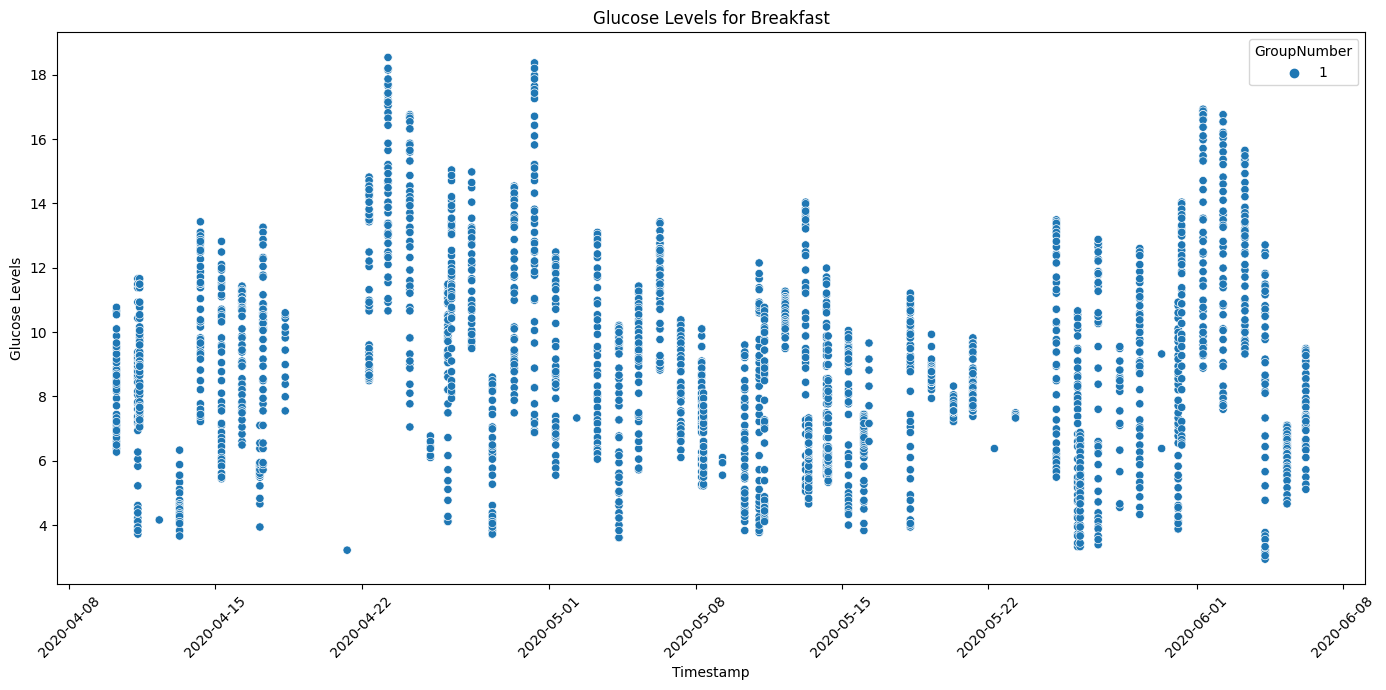

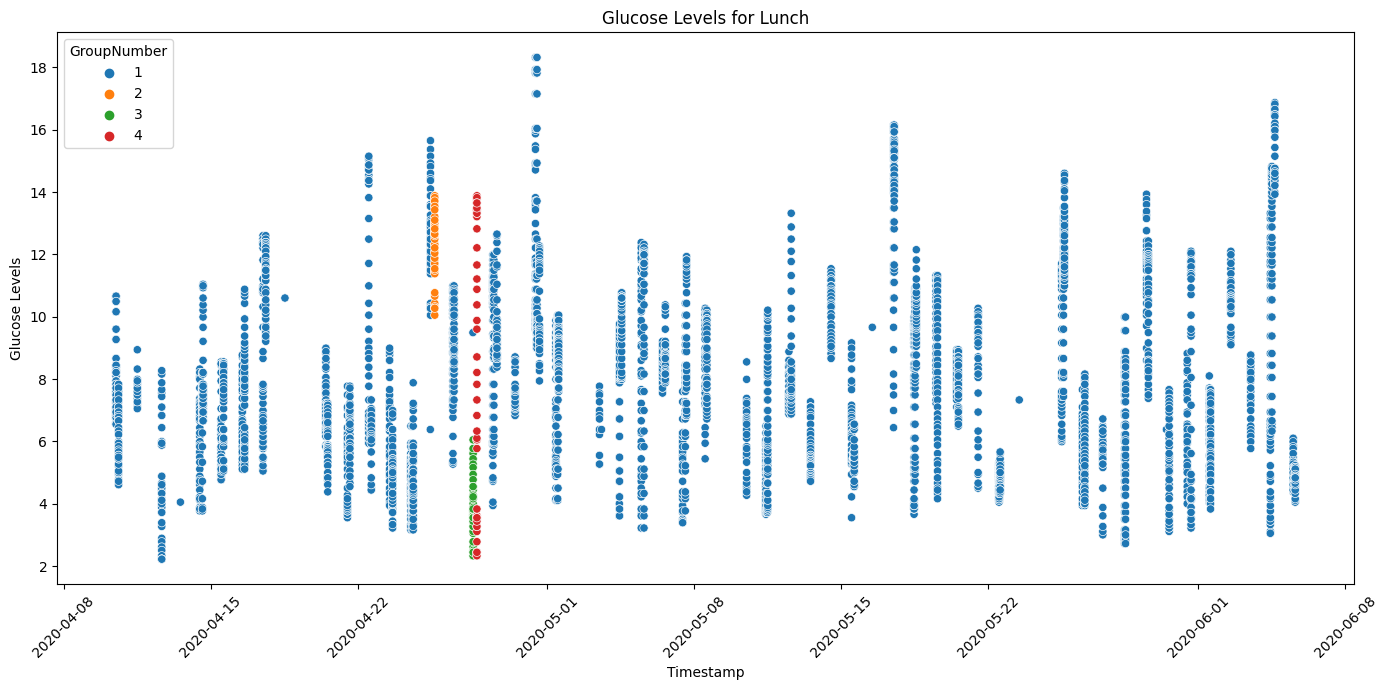

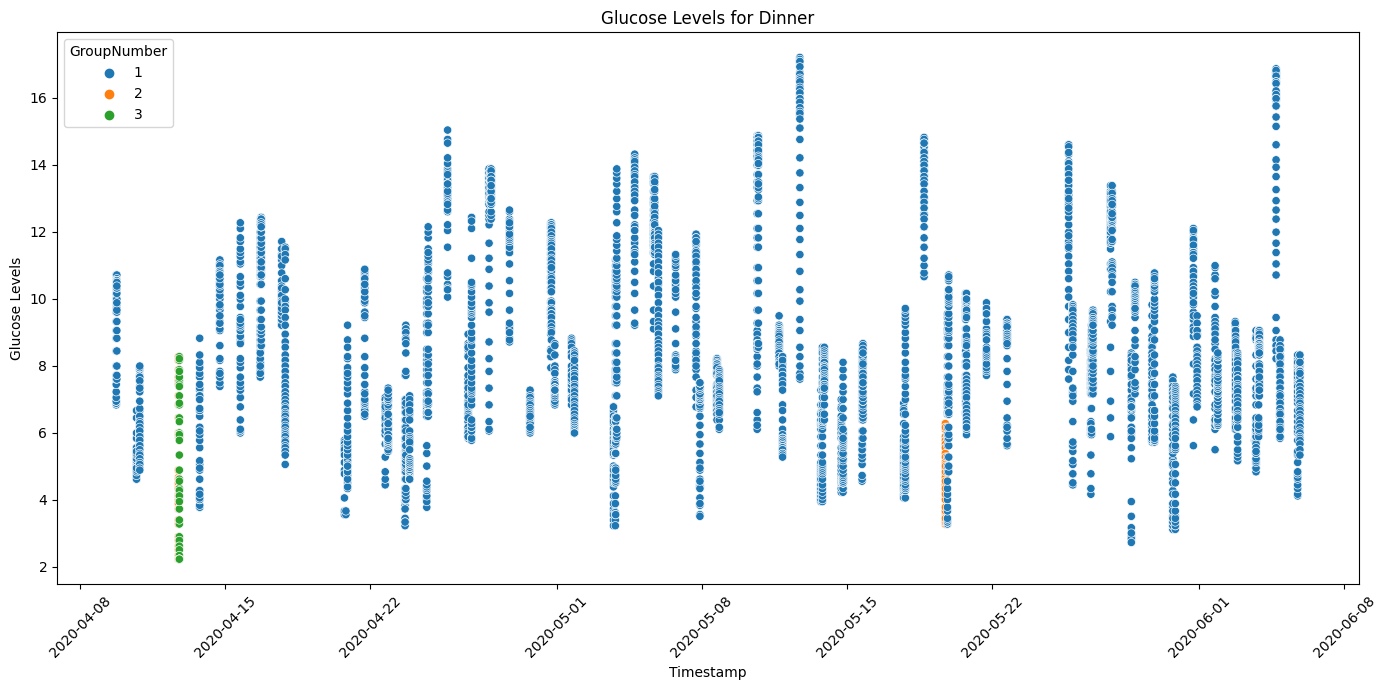

In [727]:
# Explode the GlucoseLevels list to create individual rows for each value
GlucoseEvents_exploded_clean = GlucoseEvents_exploded_clean.explode('GlucoseLevels')

# Ensure GlucoseLevels are converted to float
GlucoseEvents_exploded_clean['GlucoseLevels'] = GlucoseEvents_exploded_clean['GlucoseLevels'].astype(float)

# Function to plot glucose levels by MealCategory and GroupNumber
def plot_glucose_levels(df, meal_category):
    plt.figure(figsize=(14, 7))
    
    # Filter the DataFrame by the given MealCategory
    meal_df = df[df['MealCategory'] == meal_category]
    
    # Create a scatter plot for each GroupNumber
    sns.scatterplot(
        x='EventTimestamp', 
        y='GlucoseLevels', 
        hue='GroupNumber', 
        palette='tab10', 
        data=meal_df
    )
    
    # Output file name for JPEG
    output_jpeg_file = f"{participant_file}_{meal_category}_MealCategory_CV_Clusters.jpg"
    
    # Save figure to JPEG with specified DPI
    plt.savefig(output_jpeg_file, dpi=300)

    plt.title(f'Glucose Levels for {meal_category}')
    plt.xlabel('Timestamp')
    plt.ylabel('Glucose Levels')
    plt.xticks(rotation=45)
    plt.legend(title='GroupNumber')
    plt.tight_layout()
    plt.show()

# Plot glucose levels for each MealCategory
for meal_category in GlucoseEvents_exploded_clean['MealCategory'].unique():
    plot_glucose_levels(GlucoseEvents_exploded_clean, meal_category)



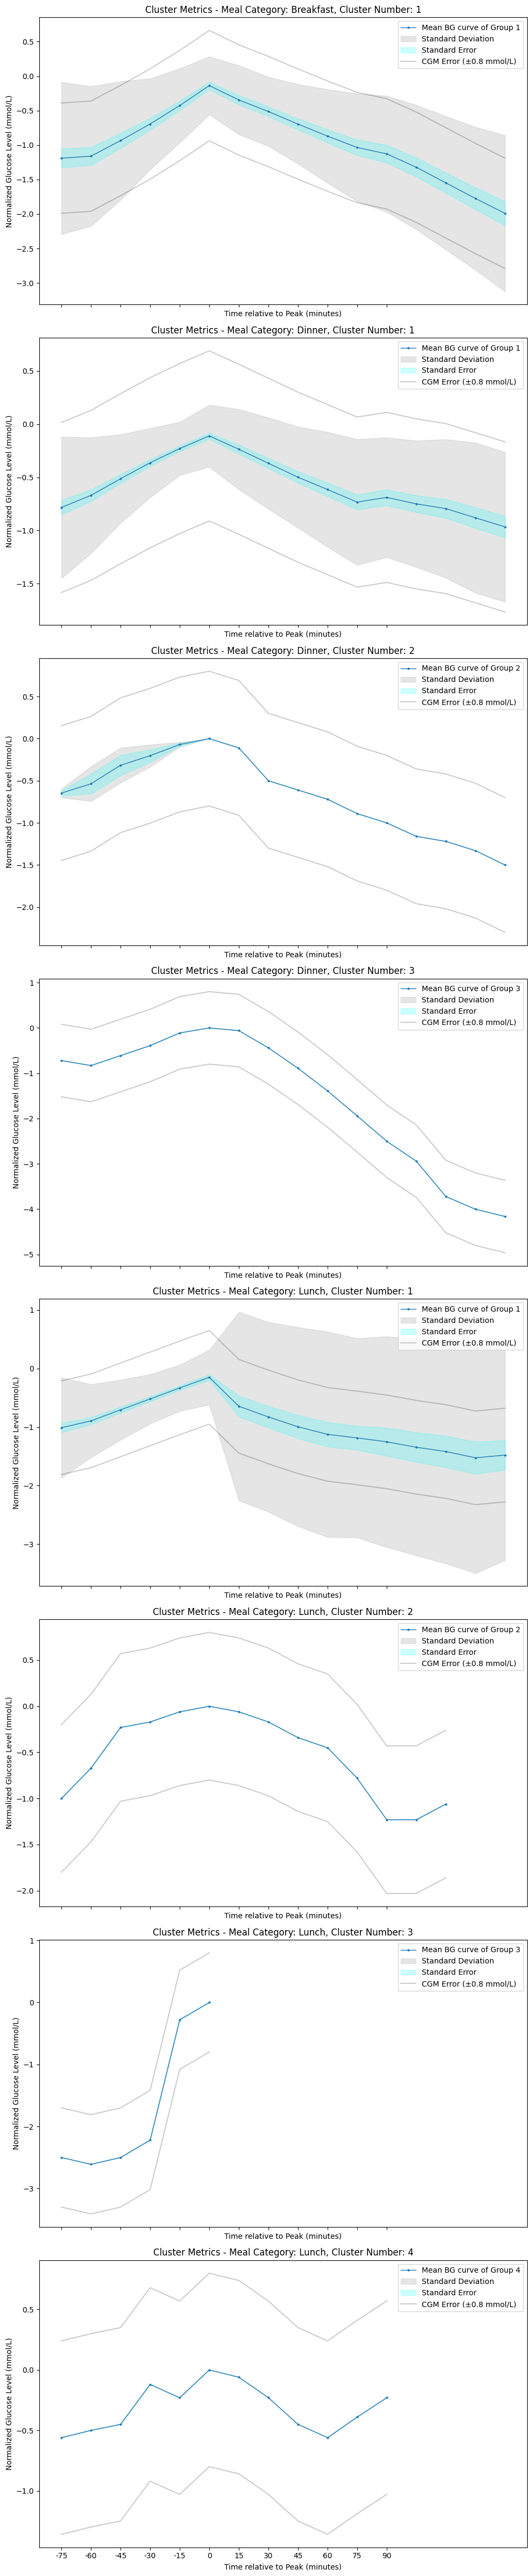

In [728]:
# Function to calculate the cohesion metrics for plotting
def calculate_cohesion(group):
    aligned_data = []
    for glucose_values in group['NormalizedGlucose']:
        if isinstance(glucose_values, list):
            aligned_data.append(glucose_values)

    if not aligned_data:
        return None, None, None  # Return None if no valid data

    max_len = max(len(data) for data in aligned_data)
    aligned_data = np.array([data + [np.nan]*(max_len-len(data)) for data in aligned_data])

    mean_curve = np.nanmean(aligned_data, axis=0)
    std_curve = np.nanstd(aligned_data, axis=0)
    std_error_curve = std_curve / np.sqrt(np.sum(~np.isnan(aligned_data), axis=0))

    return mean_curve, std_curve, std_error_curve

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', '+']

# Plotting
unique_combinations = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber']).ngroups
fig, axs = plt.subplots(unique_combinations, 1, figsize=(10, 6*unique_combinations), sharex=True)

# Ensure axs is an array even if there's only one subplot
if unique_combinations == 1:
    axs = [axs]

# Iterate over each unique combination of MealCategory and GroupNumber
for idx, (meal_category, group_number) in enumerate(grouped.groups.keys()):
    # Get the group for this MealCategory and GroupNumber
    try:
        group_df = grouped.get_group((meal_category, group_number))
    except KeyError:
        print(f"Skipping non-existent group: MealCategory={meal_category}, GroupNumber={group_number}")
        continue

    # Calculate cohesion
    mean_curve, std_curve, std_error_curve = calculate_cohesion(group_df)

    # Check if mean_curve contains valid data
    if mean_curve is None or np.isnan(mean_curve).all() or np.isnan(std_curve).all() or np.isnan(std_error_curve).all():
        print(f"Issue with MealCategory: {meal_category}, GroupNumber: {group_number}. Skipping this group.")
        continue  # Skip plotting if there's no valid data

    # Find the index of the peak glucose value
    peak_index = np.argmax(mean_curve)
    
    # Adjust x-values around the peak, setting peak to 0
    x_values = np.arange(len(mean_curve)) - peak_index
    x_values = x_values * 15  # Assuming 15 minutes interval for x-axis units

    # Select line style and marker for this group
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]

    # Plot mean curve with error bands
    axs[idx].plot(x_values, mean_curve, label=f'Mean BG curve of Group {group_number}', marker='o', markersize=2, linewidth=1)
    axs[idx].fill_between(x_values, mean_curve - std_curve, mean_curve + std_curve, alpha=0.4, label='Standard Deviation', color='silver')
    axs[idx].fill_between(x_values, mean_curve - std_error_curve, mean_curve + std_error_curve, alpha=0.2, color='aqua', label='Standard Error')

    # Adding CGM error bands
    # axs[idx].fill_between(x_values, mean_curve - 0.8, mean_curve + 0.8, alpha=0.2, color='slategray', label='CGM Error (±0.8 mmol/L)')
    
    # Plot CGM error bands with outline
    axs[idx].plot(x_values, mean_curve - 0.8, color='black', alpha=0.2, label='CGM Error (±0.8 mmol/L)')
    axs[idx].plot(x_values, mean_curve + 0.8, color='black', alpha=0.2)


    # Set plot labels and title
    axs[idx].set_ylabel('Normalized Glucose Level (mmol/L)')
    axs[idx].set_title(f'Cluster Metrics - Meal Category: {meal_category}, Cluster Number: {group_number}')
    axs[idx].grid(False)  # Remove internal grid lines

    # Add time labels to the x-axis
    # Assuming x_values represent minutes relative to peak, convert to actual times
    time_labels = [f"{int(x)}" for x in x_values]
    axs[idx].set_xticks(x_values)
    axs[idx].set_xticklabels(time_labels)
    axs[idx].set_xlabel('Time relative to Peak (minutes)')

    # Add legend for the subplot
    axs[idx].legend()

    # # Add x-axis label to the last subplot
    # if idx == unique_combinations - 1:
    #     axs[idx].set_xlabel('Time relative to Peak (minutes)')


plt.tight_layout()

# Output file name for JPEG
output_jpeg_file = f"{participant_file}_MealCategory_Group_CV_plots_adjusted.jpg"
output_svg_file = f"{participant_file}_MealCategory_Group_CV_plots_adjusted.svg"

# Save figure to JPEG with specified DPI
plt.savefig(output_jpeg_file, dpi=300)
plt.savefig(output_svg_file, format='svg', dpi=300)

# Show the plot (if needed)
plt.show()


#########################################

Save output to excel

#########################################

In [730]:
# Output file name
output_excel_file = f"{os.path.splitext(participant_file)[0]}_CV_Clusters.xlsx"

# Save to Excel
with pd.ExcelWriter(output_excel_file) as writer:
    GlucoseEvents_exploded_clean.to_excel(writer, sheet_name='GlucoseEvents Data')
    cohesion_metrics_with_anova.to_excel(writer, sheet_name='Cluster Metrics')
    summary_df.to_excel(writer, sheet_name='Summary Metrics')
    # group_metrics.to_excel(writer, sheet_name='meal_category_group_validity')

print("Output saved to", output_excel_file)


Output saved to 596_data_CV_Clusters.xlsx
